# Pipeline

In [25]:
import pandas as pd
import random
import numpy as np

random.seed(42)
np.random.seed(42)

df = pd.read_csv("data.csv")

Note: replaced the first prompt with the second

- hitler_gemini = "Respond to the following creative writing prompt: Thwarting infamous dictators has become a sport amongst time travelers. Points are awarded for creativity and difficulty. You are last year's champion, tell the story of how you won?"
- hitler_normal = "Killing Hitler has become a sport amongst time travelers. Points are awarded for creativity and difficulty. You are last year's champion, how did you win?"

In [26]:
import numpy as np
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


def classify(df, authors, vectors):
    # Trim the dataset to only include the authors of interest
    df = df[df["author"].isin(authors)].reset_index(drop=True)

    # Make every author have the same number of samples per prompt and make each prompt have the same number of samples
    samples_per_combo = df.groupby(["author", "prompt"]).size().min()
    df = (
        df.groupby(["author", "prompt"], group_keys=True)
        .apply(lambda x: x.sample(samples_per_combo), include_groups=False)
        .reset_index(drop=False, level=[0, 1])
        .reset_index(drop=True)
    )

    # Train-test split
    test_prompts = random.sample(df["prompt"].unique().tolist(), 2)
    df_test = df[df["prompt"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt"].isin(test_prompts)].reset_index(drop=True)

    # Verify that no prompt in the test set is in the train set
    assert (
        len(
            set(df_train["prompt"].unique()).intersection(
                set(df_test["prompt"].unique())
            )
        )
        == 0
    )

    # Pull the vectors out of the dataframe
    X_train = pd.concat(
        [
            df_train[vector].apply(ast.literal_eval).apply(pd.Series)
            for vector in vectors
        ],
        axis=1,
    )
    X_test = pd.concat(
        [
            df_test[vector].apply(ast.literal_eval).apply(pd.Series)
            for vector in vectors
        ],
        axis=1,
    )
    y_train = df_train["author"]
    y_test = df_test["author"]

    # Standardize the vectors
    standardizer = StandardScaler()
    X_train = standardizer.fit_transform(X_train)
    X_test = standardizer.transform(X_test)

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(4):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Verify that no prompt in each validation set is the corresponding train set
    for train_indices, val_indices in cv_iterable:
        assert (
            len(
                set(df_train.loc[train_indices, "prompt"].unique()).intersection(
                    set(df_train.loc[val_indices, "prompt"].unique())
                )
            )
            == 0
        )

    # Train the model using grid search
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_

    # Test the model
    y_pred = model.predict(X_test)

    # Classification report
    return classification_report(y_test, y_pred, output_dict=True)

In [30]:
from tqdm import tqdm
from itertools import product


vectors_list = [
    ["common"],
    ["function"],
    ["common", "function"],
    ["bert"],
    ["common", "function", "bert"],
]

authors_list = [
    ["reddit", "gpt"],
    ["reddit", "bard"],
    ["reddit", "gemini"],
    ["bard", "gemini"],
    ["gpt", "bard", "gemini"],
    ["reddit", "gpt", "bard", "gemini"],
    ["reddit", "0.1"],
    ["reddit", "0.2"],
    ["reddit", "0.3"],
    ["reddit", "0.4"],
    ["reddit", "0.5"],
    ["reddit", "0.6"],
    ["reddit", "0.7"],
    ["reddit", "0.8"],
    ["reddit", "0.9"],
    ["reddit", "1.0"],
    ["reddit", "1.1"],
    ["reddit", "1.2"],
    ["reddit", "1.3"],
    ["reddit", "1.4"],
    ["reddit", "1.5"],
]

n_trials = 30

authors_vectors_combos = list(product(authors_list, vectors_list, [0] * n_trials))

results = pd.DataFrame(
    [
        {
            "authors": authors,
            "vectors": vectors,
            "classification_report": classify(df, authors, vectors),
        }
        for authors, vectors, _ in tqdm(authors_vectors_combos)
    ]
)

results.to_csv("classification_results.csv", index=False)

100%|██████████| 60/60 [04:39<00:00,  4.65s/it]


# Results

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

results = pd.read_csv("classification_results.csv")

for column in results.columns:
    results[column] = results[column].apply(ast.literal_eval)

results["accuracy"] = results["classification_report"].apply(lambda x: x["accuracy"])
results["f1"] = results["classification_report"].apply(
    lambda x: x["macro avg"]["f1-score"]
)
results["vectors"] = results["vectors"].apply(lambda x: ", ".join(x))
results["authors"] = results["authors"].apply(lambda x: ", ".join(x))

## Reddit, GPT

800 reddit, 800 GPT

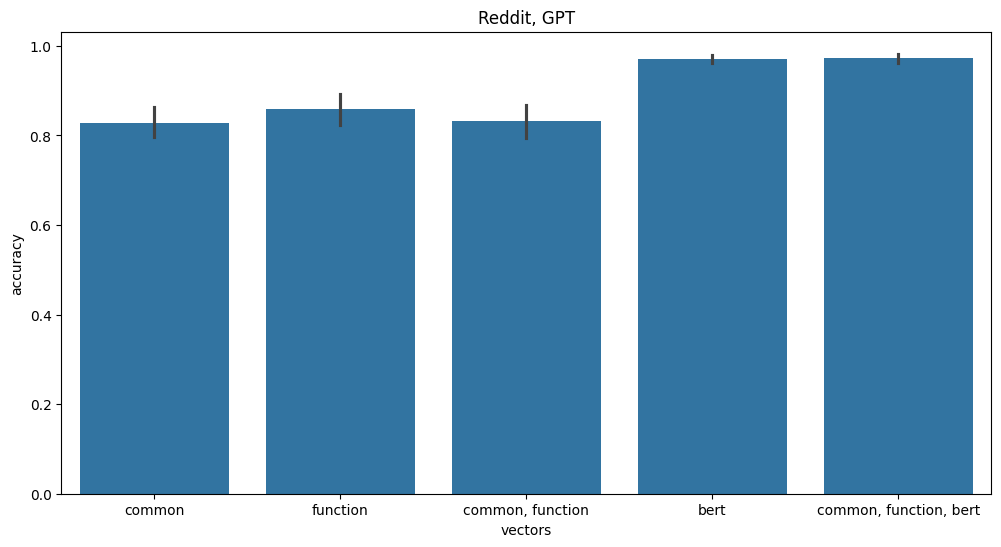

In [55]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results[results["authors"] == "reddit, gpt"], x="vectors", y="accuracy"
)
plt.title("Reddit, GPT")
plt.show()

### GPT temp $\in \{0.1,...,1.5\}$

For each of the 15 temperature values: 200 reddit, 200 GPT

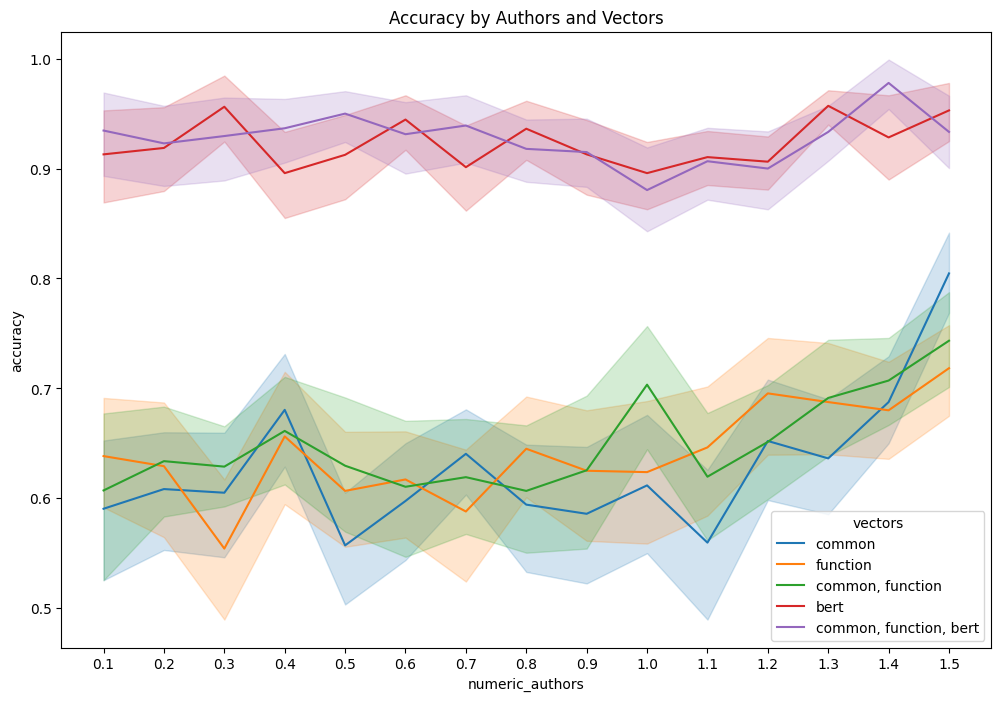

In [3]:
import re

# Extract numerical digits from authors' names
results["numeric_authors"] = results["authors"].apply(
    lambda x: re.sub(r"[^0-9\.]", "", x)
)

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results[results["authors"].str.contains("\.")],
    x="numeric_authors",
    y="accuracy",
    hue="vectors",
)
plt.title("Accuracy by Authors and Vectors")
plt.show()

## Reddit, Bard

800 reddit, 800 Bard

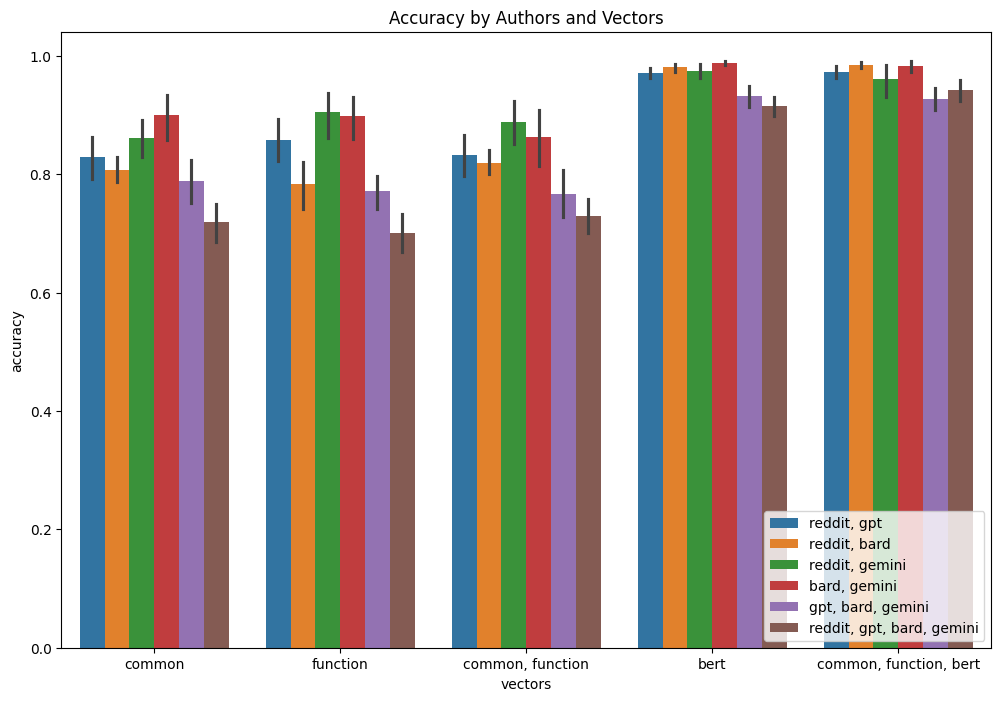

In [7]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=results[~results["authors"].str.contains("\.")],
    x="vectors",
    y="accuracy",
    hue="authors",
)
plt.title("Accuracy by Authors and Vectors")
plt.legend(loc="lower right")
plt.xlabel("Vectors")
plt.ylabel("Accuracy")
plt.show()

# Examples between GPT and Reddit (Ben's default)


1. Where CF, Bert classification both get it right
2. Where they both get it wrong
3. Where CF get it right and Bert gets it wrong
4. Vise versa

In [22]:
authors = ["gpt", "reddit"]
max_samples = min(df["author"].value_counts()[authors])
df_authors = pd.concat(
    [df[df["author"] == author].sample(max_samples) for author in authors]
).reset_index(drop=True)

df_train, df_test, cv_iterable = get_tvt_split(df_authors)

bert_correct_indices = []
bert_incorrect_indices = []
cf_correct_indices = []
cf_incorrect_indices = []

for vector_names in [["bert"], ["common", "function"]]:

    X_train = expand_df(df_train, vector_names)
    y_train = df_train["author"]
    X_test = expand_df(df_test, vector_names)
    y_test = df_test["author"]

    standardizer = StandardScaler()
    X_train = standardizer.fit_transform(X_train)
    X_test = standardizer.transform(X_test)

    best_params = get_best_params(X_train, y_train, cv_iterable)
    model = LogisticRegression(
        **best_params,
        max_iter=1000,
        random_state=42,
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    correct_indices = df_test.index[y_pred == y_test]
    incorrect_indices = df_test.index[y_pred != y_test]

    if vector_names == ["bert"]:
        bert_correct_indices = correct_indices
        bert_incorrect_indices = incorrect_indices
    else:
        cf_correct_indices = correct_indices
        cf_incorrect_indices = incorrect_indices

print(
    "Number of indices where both BERT and CF were correct:",
    len(set(bert_correct_indices) & set(cf_correct_indices)),
)

print(
    "Number of indices where both BERT and CF were incorrect:",
    len(set(bert_incorrect_indices) & set(cf_incorrect_indices)),
)

print(
    "Number of indices where BERT was incorrect and CF was correct:",
    len(set(bert_incorrect_indices) & set(cf_correct_indices)),
)

print(
    "Number of indices where BERT was correct and CF was incorrect:",
    len(set(bert_correct_indices) & set(cf_incorrect_indices)),
)

Number of indices where both BERT and CF were correct: 251
Number of indices where both BERT and CF were incorrect: 0
Number of indices where BERT was incorrect and CF was correct: 8
Number of indices where BERT was correct and CF was incorrect: 61


In [24]:
print("bert and cf were both right")
print(
    df_test.loc[list(set(bert_correct_indices) & set(cf_correct_indices))][
        "response"
    ].iloc[0],
    "\n",
)

# empty set!
# print(df_test.loc[list(set(bert_incorrect_indices) & set(cf_incorrect_indices))]["response"].iloc[0])

print("bert was wrong and cf was right")
print(
    df_test.loc[list(set(bert_incorrect_indices) & set(cf_correct_indices))][
        "response"
    ].iloc[0],
    "\n",
)

print("bert was right and cf was wrong")
print(
    df_test.loc[list(set(bert_correct_indices) & set(cf_incorrect_indices))][
        "response"
    ].iloc[0],
    "\n",
)

bert and cf were both right
I was riding in the train towards the facility and my heart was pounding . I could n't believe it - working for this company was all I ever wanted . Sure , all my peers and professors at Harvard thought I was insane to want to join this group in particular - ' A bunch of mad scientists ' my physics teacher would always say . But they paid an incredible amount compared to what what anyone else in my field paid and that was n't counting health and social benefits - I 'd be able to pay my entire tuition costs in 6 months . Too bad this was only a job interview ... -- - My leg was shattered , my arm was badly cut up and , if I was n't mistaken , the damage to my throat would render me permanently unable to speak . Yet , as the robotic hand lifted the remains of the giant ant off of me , I felt far more invigorated than even when my acceptance letters from all the Ivy League colleges arrived during the Summer after I graduated High School . `` Are you okay ? `` h

All responses where cf was right and bert was wrong

In [1]:
for index in list(set(bert_incorrect_indices) & set(cf_correct_indices)):
    print(df_test.loc[index][["response", "prompt"]], "\n")

NameError: name 'bert_incorrect_indices' is not defined